# package

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import re # 正则化相关函数
import os # 
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
import random

# data import

## import function

In [2]:
# 允许的扩展名
ALLOWED_EXTS = {".csv", ".xlsx", ".xls"}

# 统一后的“推荐列顺序”
CANONICAL_COLS = [
    "participant_id", "exp_start_time", "block_number", "block_label",
    "onset_time", "offset_time", "duration"
]

# 常见列名别名映射到“统一列名”
SYNONYMS: Dict[str, str] = {
    # participant id
    "participant": "participant_id",
    "participants": "participant_id",
    "participantid": "participant_id",
    "subject": "participant_id",
    "subject_id": "participant_id",
    "subjectid": "participant_id",
    "subj": "participant_id",
    "subjid": "participant_id",
    "id": "participant_id",  # 有些日志里就是 id

    # experiment start time
    "exp_start": "exp_start_time",
    "experiment_start_time": "exp_start_time",
    "start_time_exp": "exp_start_time",
    "expstarttime": "exp_start_time",

    # block number
    "block_no": "block_number",
    "blockindex": "block_number",
    "block_idx": "block_number",
    "blockid": "block_number",
    "block_number": "block_number",

    # block label
    "block": "block_label",
    "blocklabel": "block_label",
    "block_name": "block_label",
    "blocktype": "block_label",

    # onset / offset
    "start_time": "onset_time",
    "onset": "onset_time",
    "stim_onset": "onset_time",
    "offset": "offset_time",
    "end_time": "offset_time",
    "stop_time": "offset_time",

    # duration
    "dur": "duration",
    "block_duration": "duration",

    "recording": "recording",
    
}

def slugify_col(col: str) -> str:
    """将列名转为小写+下划线，去除特殊符号，方便统一映射。"""
    s = col.strip().lower()
    s = re.sub(r"[^\w]+", "_", s)   # 非字母数字转下划线
    s = re.sub(r"__+", "_", s)      # 连续下划线压缩
    return s.strip("_")

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """统一列名：先 slugify，再根据 SYNONYMS 映射到标准名。"""
    out = df.copy()
    out.columns = [slugify_col(c) for c in out.columns]
    rename_map = {c: SYNONYMS[c] for c in out.columns if c in SYNONYMS}
    if rename_map:
        out = out.rename(columns=rename_map)
    return out

def read_any_table(path: Path) -> pd.DataFrame:
    """读取单个文件：自动识别分隔符/编码，支持 Excel。"""
    ext = path.suffix.lower()
    if ext in {".xlsx", ".xls"}:
        df = pd.read_excel(path, sheet_name=0)
    else:
        df = None
        tried = []
        for enc in ["utf-8", "utf-8-sig", "gbk", "latin-1"]:
            try:
                # sep=None 可以自动猜测分隔符（需要 engine="python"）
                df = pd.read_csv(path, sep=None, engine="python", encoding=enc)
                break
            except Exception as e:
                tried.append((enc, str(e)))
                df = None
        if df is None:
            # 最后尝试按任意空白分隔
            for enc in ["utf-8", "latin-1"]:
                try:
                    df = pd.read_csv(path, delim_whitespace=True, engine="python", encoding=enc)
                    break
                except Exception:
                    df = None
        if df is None:
            raise RuntimeError(f"读取失败：{path}\n尝试编码与错误：{tried}")

    df = standardize_columns(df)
    df["source_file"] = path.name
    return df

def find_block_files(input_dir: Path, recursive: bool = True, pattern: str = "block") -> List[Path]:
    """查找文件名包含 pattern 的表格文件，忽略隐藏文件。"""
    pattern = pattern.lower()
    files: List[Path] = []
    if recursive:
        for p in input_dir.rglob("*"):
            if (
                p.is_file()
                and not p.name.startswith(".")  # 忽略隐藏文件
                and pattern in p.name.lower()
                and p.suffix.lower() in ALLOWED_EXTS
            ):
                files.append(p)
    else:
        for p in input_dir.iterdir():
            if (
                p.is_file()
                and not p.name.startswith(".")  # 忽略隐藏文件
                and pattern in p.name.lower()
                and p.suffix.lower() in ALLOWED_EXTS
            ):
                files.append(p)
    return sorted(files)

def combine_block_tables(input_dir: Path,
                         output_csv: Optional[Path] = None,
                         recursive: bool = True,
                         pattern: str = "block") -> pd.DataFrame:

    paths = find_block_files(input_dir, recursive=recursive, pattern=pattern)
    if not paths:
        raise FileNotFoundError(f"未在 {input_dir} 下找到包含 '{pattern}' 的文件（支持扩展名：{sorted(ALLOWED_EXTS)})")
    dfs = []
    for p in paths:
        try:
            df = read_any_table(p)
            dfs.append(df)
        except Exception as e:
            print(f"[警告] 跳过无法读取文件：{p}\n原因：{e}")

    if not dfs:
        raise RuntimeError("没有可合并的数据表。")
    big = pd.concat(dfs, ignore_index=True)

    # 统一列顺序：把标准列放前面，其它列保留在后
    front = [c for c in CANONICAL_COLS if c in big.columns]
    rest = [c for c in big.columns if c not in front]
    big = big[front + rest]

    # 先找出缺失的记录
    missing_rows = big[big[["onset_time", "offset_time"]].isna().all(axis=1)]
    if not missing_rows.empty:
        print(f"[警告] 以下记录的 onset/offset 同时缺失：\n{missing_rows}")
    big = big[big[["onset_time", "offset_time"]].notna().any(axis=1)].reset_index(drop=True)

    # 新增绝对时间列
    if {"exp_start_time", "onset_time", "offset_time"}.issubset(big.columns):
        big["exp_start_time"] = pd.to_datetime(big["exp_start_time"], errors="coerce")
        big["onset_time"] = pd.to_numeric(big["onset_time"], errors="coerce")
        big["offset_time"] = pd.to_numeric(big["offset_time"], errors="coerce")
        big["abs_onset_time"] = big["exp_start_time"] + pd.to_timedelta(big["onset_time"], unit="s")
        big["abs_offset_time"] = big["exp_start_time"] + pd.to_timedelta(big["offset_time"], unit="s")

    if output_csv:
        output_csv.parent.mkdir(parents=True, exist_ok=True)
        big.to_csv(output_csv, index=False)
    return big

## prepared data import

文件说明 
combined_blocks.csv 是没有去掉pra和无效被试和重复block的block汇总文件
combined_blocks_final.csv 是清洗后的block

ergolab_contain_block ergolab项目跟每个被试的block相关性


In [6]:
BASE = Path('/Volumes/LYY_T7/13_抽象实验数据分析')
DERIV = BASE / '3_derivatives'
BEHAV = DERIV / 'behavior'
PHYS = DERIV / 'physio'

# Derivative inputs (如存在则读取)
p_blocks_psychopy = BEHAV / 'combined_blocks_final.csv'
p_blocks_ergolab_merged_cleaned = BEHAV / 'blocks_ergolab_merged_cleaned.csv'
p_cleaned_events = BEHAV / 'combined_events_final.csv'
p_cleaned_clicks = BEHAV / 'combined_clicks_final_dedup.csv'
p_click_summary = BEHAV / 'clicks_summary.csv'
p_event_summary = BEHAV / 'event_summary.csv'
p_fa_full = BEHAV / 'fa_counts_full.csv'

p_ergolab_contain_block = PHYS / 'ergolab_contain_block.xlsx'
p_ergolab_info_summary = PHYS / 'ergolab_info_summary.csv'

p_que_block_filtered = BEHAV / 'questionnaire_block_cleaned.csv'


# Parameters
TARGETS_PER_BLOCK = 54
RT_OFFSET_SECONDS = 1.3

BEHAV.mkdir(parents=True, exist_ok=True)

def _read_opt(path: Path):
    if path is None:
        return None
    if not path.exists():
        print(f'[skip] Not found: {path}')
        return None
    if path.suffix.lower() in {'.xlsx', '.xls'}:
        df = pd.read_excel(path, sheet_name=0)
    else:
        df = pd.read_csv(path)
    print(f'[load] {path} shape={df.shape}')
    return df

blocks_psychopy = _read_opt(p_blocks_psychopy)
blocks_ergolab_merged_cleaned = _read_opt(p_blocks_ergolab_merged_cleaned)
cleaned_events = _read_opt(p_cleaned_events)
ergolab_contain_block = _read_opt(p_ergolab_contain_block)
ergolab_info_summary = _read_opt(p_ergolab_info_summary)
cleaned_clicks = _read_opt(p_cleaned_clicks)
event_summary = _read_opt(p_event_summary)
clicks_summary = _read_opt(p_click_summary)
fa_full = _read_opt(p_fa_full)
que_block_filtered = _read_opt(p_que_block_filtered)

[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/combined_blocks_final.csv shape=(279, 10)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/blocks_ergolab_merged_cleaned.csv shape=(280, 12)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/combined_events_final.csv shape=(15080, 14)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/physio/ergolab_contain_block.xlsx shape=(304, 3)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/physio/ergolab_info_summary.csv shape=(50, 3)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/combined_clicks_final_dedup.csv shape=(15182, 15)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/event_summary.csv shape=(279, 5)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/clicks_summary.csv shape=(279, 3)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/fa_counts_full.csv shape=(304, 6)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/questionnaire_block_cleaned.csv shape=(280, 10)


In [7]:
# 得到block所有信息的汇总表格
blocks_ergolab_merged_cleaned['participant_id'] = pd.to_numeric(blocks_ergolab_merged_cleaned['participant_id'], errors='coerce').astype('Int64')
blocks_summary = blocks_ergolab_merged_cleaned.merge(clicks_summary, on=["participant_id", "block_label"], how="left")
blocks_summary = blocks_summary.merge(event_summary, on=["participant_id", "block_label"], how="left")
blocks_summary = blocks_summary.merge(fa_full, on=["participant_id", "block_label"], how="left")
blocks_summary = blocks_summary.merge(que_block_filtered,on=["participant_id", "block_label"], how="left")
print(blocks_summary.columns)
# 重新安排列的顺序
blocks_summary = blocks_summary[[
    # 标识符
    "participant_id", "block_label", 
    # 程序时间
    "exp_start_time",  "abs_onset_time", "abs_offset_time", "onset_time", "offset_time", "duration",
    # ergolab项目时间相关数据
    "create_time", "recording",
    # 行为指标
    "click_count", "is_hit", "hit_rate", "Reaction_time", "fa_count",
    # 主观指标
    "mental_demand", "physical_demand", "temporal_demand", "effort", "frustration", "performance", "SSS", "perceived_difficulty"
]]

# 行根据participant_id 和 block_label排序
blocks_summary = blocks_summary.sort_values(by=["participant_id", "block_label"], kind="mer")
blocks_summary

Index(['participant_id', 'exp_start_time', 'block_number', 'block_label',
       'onset_time', 'offset_time', 'duration', 'source_file',
       'abs_onset_time', 'abs_offset_time', 'recording', 'create_time',
       'click_count', 'is_hit', 'hit_rate', 'Reaction_time', 'fa_count',
       'id_lab', 'disturbance_count', 'fa_rate', 'mental_demand',
       'physical_demand', 'temporal_demand', 'effort', 'frustration',
       'performance', 'SSS', 'perceived_difficulty'],
      dtype='object')


,participant_id,block_label,exp_start_time,abs_onset_time,abs_offset_time,onset_time,offset_time,duration,create_time,recording,...,Reaction_time,fa_count,mental_demand,physical_demand,temporal_demand,effort,frustration,performance,SSS,perceived_difficulty
9,1,A,2025-07-22 13:45:57.389,2025-07-22 13:48:29.483819100,2025-07-22 13:54:31.467702000,152.094819,514.078702,361.983883,2025-07-22 13:42:01.581,R1,...,0.744810,4,28.0,25.0,19.0,35.0,37.0,77.0,4.0,3.0
10,1,B,2025-07-22 13:45:57.389,2025-07-22 13:56:31.232449200,2025-07-22 14:02:33.211943100,633.843449,995.822943,361.979494,2025-07-22 13:42:01.581,R1,...,0.627677,0,36.0,24.0,23.0,40.0,30.0,80.0,3.0,5.0
11,1,C,2025-07-22 14:13:31.431,2025-07-22 14:29:41.376233000,2025-07-22 14:35:43.352902000,969.945233,1331.921902,361.976669,2025-07-22 14:13:15.901,R2,...,0.805190,1,24.0,28.0,16.0,41.0,25.0,83.0,3.0,2.0
12,1,D,2025-07-22 14:39:56.601,2025-07-22 14:52:47.663034200,2025-07-22 14:58:49.642241600,771.062034,1133.041242,361.979207,2025-07-22 14:39:42.059,R3,...,0.810832,2,26.0,20.0,18.0,36.0,21.0,86.0,2.0,2.0
13,1,E,2025-07-22 15:01:08.005,2025-07-22 15:14:19.449769700,2025-07-22 15:25:32.426622100,791.444770,1464.421622,672.976852,2025-07-22 14:39:42.059,R3,...,0.624608,1,27.0,21.0,15.0,33.0,15.0,82.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,38,D,2025-07-30 13:39:14.258,2025-07-30 13:41:45.211267900,2025-07-30 13:47:47.186707300,150.953268,512.928707,361.975439,2025-07-30 13:33:59.529,R1,...,1.000228,6,60.0,40.0,75.0,80.0,35.0,75.0,2.0,5.0
277,38,E,2025-07-30 14:02:32.576,2025-07-30 14:02:49.419636500,2025-07-30 14:14:02.393826700,16.843637,689.817827,672.974190,2025-07-30 13:33:59.529,R1,...,0.650123,4,60.0,30.0,25.0,70.0,30.0,88.0,3.0,2.0
278,38,F,2025-07-30 13:39:14.258,2025-07-30 13:49:55.071123900,2025-07-30 14:01:08.042298800,640.813124,1313.784299,672.971175,2025-07-30 13:33:59.529,R1,...,0.700788,4,65.0,30.0,40.0,75.0,35.0,85.0,2.0,3.0
8,38,G,2025-07-30 15:07:48.381,2025-07-30 15:08:00.297901400,2025-07-30 15:19:13.281365300,11.916901,684.900365,672.983464,2025-07-30 15:07:30.738,R2,...,0.973975,2,60.0,30.0,45.0,65.0,50.0,85.0,3.0,3.0


# data prepare


## import block data and merge

In [27]:
# INPUT_DIR = r"/Volumes/LYY_T7/13_抽象实验数据分析/1_rawdata/behavior"   # 比如 r"D:\Experiment\logs"
# OUTPUT_DIR = r"/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior"       # 可选，合并结果输出目录
# FILENAME_PATTERN = "block"            # 只匹配文件名包含该字符串
# RECURSIVE = False                      # 是否递归子目录

# # ===== 执行合并 =====
# input_dir = Path(INPUT_DIR)
# output_dir = Path(OUTPUT_DIR) if OUTPUT_DIR else input_dir
# output_combined = output_dir / "combined_blocks.csv"

# combined_blocks = combine_block_tables(
#     input_dir=input_dir,
#     output_csv=output_combined,
#     recursive=RECURSIVE,
#     pattern=FILENAME_PATTERN
# )

# print(f"[完成] 合并后形状：{combined_blocks.shape}")
# print(f"[保存] {output_combined}")

# display(combined_blocks.head(10))


## import event data

In [28]:
# EVENT_FILE_SUFFIX = "_events.csv"  # 目标文件名后缀（小写比较）
# ENCODINGS = ("utf-8", "utf-8-sig", "gbk", "latin-1")

# # 你希望导出的列顺序（按你给的拼写：block_lable）
# OUT_COLS = [
#     "participant_id", "block_label", "event_uid", "vehicle_id", "event_type",
#     "risk_count", "start_time", "end_time", "time_window",
#     "is_hit", "is_miss", "is_false_alarm", "first_click_ts"
# ]

# def _robust_read_csv(path: Path):
#     """多编码 + 分隔符自动识别读取 CSV；失败则尝试空白分隔。"""
#     last_err = None
#     for enc in ENCODINGS:
#         try:
#             # sep=None + engine="python" 自动猜分隔符（逗号/制表等）
#             return pd.read_csv(path, sep=None, engine="python", encoding=enc)
#         except Exception as e:
#             last_err = e
#     # 兜底：空白分隔
#     for enc in ENCODINGS:
#         try:
#             return pd.read_csv(path, delim_whitespace=True, engine="python", encoding=enc)
#         except Exception as e:
#             last_err = e
#     raise RuntimeError(f"读取失败：{path} -> {last_err}")

# def _parse_participant_id_from_filename(path: Path) -> str | None:
#     """
#     从文件名解析被试编号：
#       1) 开头连续数字 + 下划线： 001_...
#       2) 或包含 p数字： p01 / p001 等
#     返回 3 位字符串，如 '001'
#     """
#     name = path.name
#     m = re.match(r"^0*(\d+)_", name)
#     if m:
#         return m.group(1).zfill(3)
#     m = re.search(r"(?i)p0*(\d+)", name)
#     if m:
#         return m.group(1).zfill(3)
#     return None

# def _to_bool_series(s: pd.Series) -> pd.Series:
#     """将 'TRUE'/'FALSE'/1/0/True/False 等转为布尔，其他保持缺失。"""
#     if s is None:
#         return s
#     mapping = {
#         "true": True, "false": False,
#         "1": True, "0": False,
#         1: True, 0: False,
#         True: True, False: False
#     }
#     return s.map(lambda x: mapping.get(str(x).strip().lower(), pd.NA))

# def _coerce_numeric(df: pd.DataFrame, cols: list[str]) -> None:
#     for c in cols:
#         if c in df.columns:
#             df[c] = pd.to_numeric(df[c], errors="coerce")

# def read_and_tidy_events_file(path: Path) -> pd.DataFrame:
#     """读取单个 events 文件并整理为统一列；添加 participant_id。"""
#     df = _robust_read_csv(path)
    
#     # 需存在的列清单
#     needed = {
#         "block_label", "event_uid", "vehicle_id", "event_type", "risk_count",
#         "start_time", "end_time", "time_window",
#         "is_hit", "is_miss", "is_false_alarm", "first_click_ts"
#     }
#     missing = [c for c in needed if c not in df.columns]
#     if missing:
#         # 尽量不报错：缺的列补 NA，避免中断
#         for c in missing:
#             df[c] = pd.NA

#     # 解析 participant_id
#     pid = _parse_participant_id_from_filename(path)
#     df["participant_id"] = pid

#     # 类型清洗
#     _coerce_numeric(df, ["vehicle_id", "risk_count", "start_time", "end_time", "first_click_ts"])
#     for bcol in ["is_hit", "is_miss", "is_false_alarm"]:
#         if bcol in df.columns:
#             df[bcol] = _to_bool_series(df[bcol])

#     # 保留并排序目标列
#     df = df[[c for c in OUT_COLS if c in df.columns]].copy()

#     # 溯源列（可选）
#     df["source_file"] = path.name
#     return df

# def combine_events(input_dir: Path, recursive: bool = True, suffix: str = EVENT_FILE_SUFFIX) -> pd.DataFrame:
#     """合并目录下所有 *_events.csv 为统一总表。"""
#     files = []
#     if recursive:
#         for p in input_dir.rglob("*.csv"):
#             if p.name.lower().endswith(suffix):
#                 files.append(p)
#     else:
#         for p in input_dir.glob("*.csv"):
#             if p.name.lower().endswith(suffix):
#                 files.append(p)

#     if not files:
#         raise FileNotFoundError(f"未在 {input_dir} 发现匹配 {suffix} 的文件")

#     dfs = []
#     for p in sorted(files):
#         try:
#             dfs.append(read_and_tidy_events_file(p))
#         except Exception as e:
#             print(f"[警告] 跳过：{p} -> {e}")

#     if not dfs:
#         raise RuntimeError("没有可合并的数据（全部读取失败）。")

#     big = pd.concat(dfs, ignore_index=True)

#     # 统一列顺序（缺失列自动补 NA）
#     for c in OUT_COLS:
#         if c not in big.columns:
#             big[c] = pd.NA
#     big = big[OUT_COLS + ["source_file"]]

#     # 按被试、block、时间排序便于检查
#     sort_cols = [c for c in ["participant_id", "block_lable", "start_time"] if c in big.columns]
#     if sort_cols:
#         big = big.sort_values(sort_cols, kind="mergesort").reset_index(drop=True)

#     return big


In [29]:
# # ===== 修改为你的目录 =====
# INPUT_DIR = Path(r"/Volumes/LYY_T7/13_抽象实验数据分析/1_rawdata/behavior")
# OUTPUT_CSV = "/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/combined_events.csv"

# combined_events = combine_events(INPUT_DIR, recursive=True)
# combined_events.to_csv(OUTPUT_CSV, index=False, encoding="utf-8-sig")

# print(f"[完成] 合并结果形状：{combined_events.shape}")
# print(f"[保存] {OUTPUT_CSV}")
# display(combined_events.head(10))


## import click data

In [23]:
EVENT_FILE_SUFFIX = "clicks.csv"  # 目标文件名后缀（小写比较）
ENCODINGS = ("utf-8", "utf-8-sig", "gbk", "latin-1")

# 你希望导出的列顺序（按你给的拼写：block_lable）
OUT_COLS = [
   "participant_id","block_label", "ts","x","y",
   "vehicle_id", "risk_count", "event_uid", "event_type", "phase",
   "is_hit", "is_false_alarm"
]

def _robust_read_csv(path: Path):
    """多编码 + 分隔符自动识别读取 CSV；失败则尝试空白分隔。"""
    last_err = None
    for enc in ENCODINGS:
        try:
            # sep=None + engine="python" 自动猜分隔符（逗号/制表等）
            return pd.read_csv(path, sep=None, engine="python", encoding=enc)
        except Exception as e:
            last_err = e
    # 兜底：空白分隔
    for enc in ENCODINGS:
        try:
            return pd.read_csv(path, delim_whitespace=True, engine="python", encoding=enc)
        except Exception as e:
            last_err = e
    raise RuntimeError(f"读取失败：{path} -> {last_err}")

def _parse_participant_id_from_filename(path: Path) -> str | None:
    """
    从文件名解析被试编号：
      1) 开头连续数字 + 下划线： 001_...
      2) 或包含 p数字： p01 / p001 等
    返回 3 位字符串，如 '001'
    """
    name = path.name
    m = re.match(r"^0*(\d+)_", name)
    if m:
        return m.group(1).zfill(3)
    m = re.search(r"(?i)p0*(\d+)", name)
    if m:
        return m.group(1).zfill(3)
    return None

def _to_bool_series(s: pd.Series) -> pd.Series:
    """将 'TRUE'/'FALSE'/1/0/True/False 等转为布尔，其他保持缺失。"""
    if s is None:
        return s
    mapping = {
        "true": True, "false": False,
        "1": True, "0": False,
        1: True, 0: False,
        True: True, False: False
    }
    return s.map(lambda x: mapping.get(str(x).strip().lower(), pd.NA))

def _coerce_numeric(df: pd.DataFrame, cols: list[str]) -> None:
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

def read_and_tidy_events_file(path: Path) -> pd.DataFrame:
    """读取单个 events 文件并整理为统一列；添加 participant_id。"""
    df = _robust_read_csv(path)
    
    # 需存在的列清单
    needed = {
        "participant_id", "block_label", "event_uid","ts","x","y","vehicle_id", "risk_count", "event_type", "phase",
        "is_hit", "is_false_alarm"
    }
    missing = [c for c in needed if c not in df.columns]
    if missing:
        # 尽量不报错：缺的列补 NA，避免中断
        for c in missing:
            df[c] = pd.NA

    # 解析 participant_id
    pid = _parse_participant_id_from_filename(path)
    df["participant_id"] = pid

    # 类型清洗
    _coerce_numeric(df, ["vehicle_id", "ts", "x", "y"])
    for bcol in ["is_hit", "is_miss", "is_false_alarm"]:
        if bcol in df.columns:
            df[bcol] = _to_bool_series(df[bcol])

    # 保留并排序目标列
    df = df[[c for c in OUT_COLS if c in df.columns]].copy()

    # 溯源列（可选）
    df["source_file"] = path.name
    return df

def combine_clicks(input_dir: Path, recursive: bool = True, suffix: str = EVENT_FILE_SUFFIX) -> pd.DataFrame:
    """合并目录下所有 *_clicks.csv 为统一总表。"""
    files = []
    if recursive:
        for p in input_dir.rglob("*.csv"):
            if p.name.lower().endswith(suffix):
                files.append(p)
    else:
        for p in input_dir.glob("*.csv"):
            if p.name.lower().endswith(suffix):
                files.append(p)

    if not files:
        raise FileNotFoundError(f"未在 {input_dir} 发现匹配 {suffix} 的文件")

    dfs = []
    for p in sorted(files):
        try:
            dfs.append(read_and_tidy_events_file(p))
        except Exception as e:
            print(f"[警告] 跳过：{p} -> {e}")

    if not dfs:
        raise RuntimeError("没有可合并的数据（全部读取失败）。")

    big = pd.concat(dfs, ignore_index=True)

    # 统一列顺序（缺失列自动补 NA）
    for c in OUT_COLS:
        if c not in big.columns:
            big[c] = pd.NA
    big = big[OUT_COLS + ["source_file"]]

    # 按被试、block、时间排序便于检查
    sort_cols = [c for c in ["participant_id", "block_lable"] if c in big.columns]
    if sort_cols:
        big = big.sort_values(sort_cols, kind="mergesort").reset_index(drop=True)

    return big


In [24]:
# ===== 修改为你的目录 =====
INPUT_DIR = Path(r"/Volumes/LYY_T7/13_抽象实验数据分析/1_rawdata/behavior")
OUTPUT_CSV = "/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/combined_clicks.csv"

combined_clicks = combine_clicks(INPUT_DIR, recursive=True)
combined_clicks.to_csv(OUTPUT_CSV, index=False, encoding="utf-8-sig")

print(f"[完成] 合并结果形状：{combined_clicks.shape}")
print(f"[保存] {OUTPUT_CSV}")
display(combined_clicks.head(10))


[完成] 合并结果形状：(15731, 13)
[保存] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/combined_clicks.csv


,participant_id,block_label,ts,x,y,vehicle_id,risk_count,event_uid,event_type,phase,is_hit,is_false_alarm,source_file
0,001,pra,30.407171,-0.073148,0.070370,4,1,v3_r1_1,DISTURBANCE,disturbance,False,True,001_circleEXP_VER2_20250722_134557_clicks.csv
1,001,pra,47.450137,-0.398148,0.263889,0,1,v0_r1_12,RISK_SLOW,risk,True,False,001_circleEXP_VER2_20250722_134557_clicks.csv
2,001,pra,60.461019,0.428704,0.373148,2,1,v2_r1_5,RISK_SLOW,risk,True,False,001_circleEXP_VER2_20250722_134557_clicks.csv
3,001,pra,65.822287,-0.026852,0.260185,1,1,v1_r1_8,RISK_SLOW,risk,True,False,001_circleEXP_VER2_20250722_134557_clicks.csv
4,001,pra,85.386508,-0.508333,0.012963,3,1,v3_r1_5,RISK_FAST,risk,True,False,001_circleEXP_VER2_20250722_134557_clicks.csv
5,001,pra,90.767982,-0.017593,0.003704,4,1,v3_r1_5,RISK_FAST,risk,True,False,001_circleEXP_VER2_20250722_134557_clicks.csv
6,001,pra,96.801713,0.405556,-0.021296,5,1,v3_r1_5,RISK_FAST,risk,True,False,001_circleEXP_VER2_20250722_134557_clicks.csv
7,001,pra,115.686734,-0.374074,-0.373148,6,1,v0_r1_12,RISK_SLOW,risk,True,False,001_circleEXP_VER2_20250722_134557_clicks.csv
8,001,pra,123.423799,0.075926,-0.336111,7,1,v1_r1_8,RISK_SLOW,risk,True,False,001_circleEXP_VER2_20250722_134557_clicks.csv
9,001,pra,130.508427,0.410185,-0.325000,8,1,v2_r1_5,RISK_SLOW,risk,True,False,001_circleEXP_VER2_20250722_134557_clicks.csv


## clean useless recording

In [30]:
# blocks_cleaned = combined_blocks[combined_blocks["block_label"] != "pra"].reset_index(drop=True)

# runs_check = (
#     blocks_cleaned
#     .groupby(["participant_id", "block_label"], dropna=False)
#     .agg(duration_min=("duration", "min"), 
#          duration_max=("duration", "max"),
#          n_rows=("source_file", "size"))
#     .reset_index()
#     .sort_values(["participant_id", "block_label", "duration_min"])
# )




#### 有问题的被试
- 37号全部不用
- 33号少做一个block

1. 做了两遍，取duration大的那一遍
	- 8号的B（trial数据已删除）
	- 11号的A
	- 11号的D
	- 27号的G
	- 32号的E
2. 做了两遍，取开始时间晚的那条记录
	- 11号的C 取开始时间后面的那条记录
	- 27号的C  第一次的心率数据没有记上取开始时间后面的那条记录
	- 38号的G（C的最后2分钟没有录上，G取第二次）

In [31]:
# blocks_cleaned = combined_blocks[combined_blocks["block_label"] != "pra"].reset_index(drop=True)

# # 先定义你的特殊筛选规则
# duration_max_blocks = [
#     ("8", "B"),
#     ("11", "A"),
#     ("11", "D"),
#     ("27", "G"),
#     ("32", "E"),
# ]
# start_time_max_blocks = [
#     ("11", "C"),
#     ("27", "C"),
#     ("38", "G"),
# ]

# # 1. 特殊规则筛选
# df_duration_max = pd.concat([
#     blocks_cleaned[
#         (blocks_cleaned["participant_id"].astype(str) == pid) &
#         (blocks_cleaned["block_label"] == label)
#     ].sort_values("duration", ascending=False).head(1)
#     for pid, label in duration_max_blocks
# ], ignore_index=True)

# df_start_time_max = pd.concat([
#     blocks_cleaned[
#         (blocks_cleaned["participant_id"].astype(str) == pid) &
#         (blocks_cleaned["block_label"] == label)
#     ].assign(exp_start_time=pd.to_datetime(blocks_cleaned["exp_start_time"], errors="coerce"))
#      .sort_values("exp_start_time", ascending=False).head(1)
#     for pid, label in start_time_max_blocks
# ], ignore_index=True)

# # 2. 其它 block 默认保留 duration 最大
# special_blocks = set(duration_max_blocks + start_time_max_blocks)
# other_blocks = blocks_cleaned[
#     ~blocks_cleaned.apply(
#         lambda row: (str(row["participant_id"]), row["block_label"]) in special_blocks,
#         axis=1
#     )
# ]
# df_other = (
#     other_blocks
#     .groupby(["participant_id", "block_label"], dropna=False)
#     .apply(lambda g: g.sort_values("duration", ascending=False).head(1))
#     .reset_index(drop=True)
# )

# # 3. 合并所有结果
# final_blocks_all = pd.concat([df_duration_max, df_start_time_max, df_other], ignore_index=True)

# display(final_blocks_all)

In [32]:
# final_blocks_all.to_csv("/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/combined_blocks_final.csv", index=False)

In [33]:
# # 分类汇总每个participant有多少个block
# blocks_check = (
#     blocks_cleaned
#     .groupby("participant_id", dropna=False)
#     .agg(n_blocks=("block_label", "nunique"))
#     .reset_index()
# )

# display(blocks_check)

## ergolab data import prepare

In [34]:
# def _read_text_multi_enc(file_path: Path) -> str:
#     """
#     尝试用多种编码读取文本文件。
#     优先使用 'utf-8-sig' 来自动处理BOM。
#     """
#     # 将 'utf-8-sig' 放在最前面
#     encodings = ['utf-8-sig', 'utf-8', 'gbk', 'gb2312', 'latin-1']
#     for enc in encodings:
#         try:
#             return file_path.read_text(encoding=enc)
#         except (UnicodeDecodeError, TypeError):
#             continue
#     raise ValueError(f"无法用任何预设编码打开文件: {file_path}")

# def _parse_info_text(txt: str):
#     """从 info.csv 文本中提取三行：Recording / Subject / Create Time（分隔符更鲁棒）"""
#     rec = subj = ctime = None
#     for line in txt.splitlines():
#         # print(f"[解析] 处理行：{line}")  # 调试输出
#         line = line.strip()
#         if not line:
#             continue
#         # 分隔符可以是 : , - \t 或至少一个空格
#         for key in ("Recording", "Subject", "Create Time"):
#             # print(f"[解析] 尝试匹配 {key}...")
#             m = re.match(rf'(?i)^\s*{re.escape(key)}\s*[:,\-\t ]+\s*(.+)$', line)
#             # print(f"[解析] 匹配结果：{m}")
#             if m:
#                 val = m.group(1).strip()
#                 if key == "Recording":
#                     rec = val
#                 elif key == "Subject":
#                     subj = val
#                 else:
#                     ctime = val
#                 break
#     return rec, subj, ctime

# def _extract_ids(recording_raw: str, subject_raw: str):
#     """从 Recording/Subject 中提取 participants(3位) 与 recording(R+数字)"""
#     pid = None
#     rid = None

#     if recording_raw:
#         # 兼容 p01-r1 / P001_R2 / p12r3 等写法
#         m = re.search(r'(?i)p\D*0*(\d+)\D*r\D*0*(\d+)', recording_raw)
#         if m:
#             pid = m.group(1).zfill(3)
#             rid = f"R{int(m.group(2))}"

#     if pid is None and subject_raw:  # 兜底：例如“被试001”
#         m = re.search(r'(\d{1,3})', subject_raw)
#         if m:
#             pid = m.group(1).zfill(3)

#     return pid, rid

# def parse_info_to_row(info_path: Path) -> dict:
#     """把单个 info.csv 解析为一行记录（participants, recording, Create_Time）"""
#     txt = _read_text_multi_enc(info_path)
#     rec_raw, subj_raw, ctime_raw = _parse_info_text(txt)
#     pid, rid = _extract_ids(rec_raw, subj_raw)

#     # 规范化时间字符串（能 parse 就格式化到毫秒）
#     ctime_norm = pd.to_datetime(ctime_raw, errors="coerce")
#     if pd.notna(ctime_norm):
#         ctime_out = ctime_norm.strftime("%Y-%m-%d %H:%M:%S.%f").rstrip("0").rstrip(".")
#     else:
#         ctime_out = ctime_raw  # 无法解析就原样保留

#     return {
#         "participants": pid,      # '001'
#         "recording": rid,         # 'R1'
#         "Create_Time": ctime_out, # '2025-07-22 13:42:01.581'
#         # 可选调试字段（需要时解注释）
#         # "_recording_raw": rec_raw,
#         # "_subject_raw": subj_raw,
#         # "_info_path": str(info_path),
#     }



# BASE_DIR = Path(r"/Volumes/LYY_T7/13_抽象实验数据分析/1_rawdata/physio/ergolabtime")

# rows = []
# for p in BASE_DIR.rglob("*Info.csv"):
#     # print(f"[读取] {p}")  # 显示所有被找到的 info.csv 路径
#     try:
#         rows.append(parse_info_to_row(p))
#     except Exception as e:
#         print(f"[警告] 解析失败：{p} -> {e}")

# info_df = pd.DataFrame(rows)

# # 排序更友好（participants 升序，recording 按数字顺序）
# if not info_df.empty and "recording" in info_df.columns:
#     rec_num = info_df["recording"].str.extract(r'R(\d+)', expand=False)
#     info_df["_rec_num"] = pd.to_numeric(rec_num, errors="coerce")
#     info_df = info_df.sort_values(["participants", "_rec_num"]).drop(columns=["_rec_num"])

# # display(info_df.head(20))

# # 保存
# out_csv =  "./ergolab_info_summary.csv"
# info_df.to_csv(out_csv, index=False, encoding="utf-8-sig")
# print("[保存] ->", out_csv)


## clean event data

In [35]:
# def clean_events_by_windows_simple(events_df: pd.DataFrame,
#                                    windows_df: pd.DataFrame,
#                                    drop_pids=(9,26,37),
#                                    drop_pra=True,
#                                    strict_no_window=True):
#     """
#     三步清洗：
#       1) 去掉 block_label == 'pra'（不区分大小写）
#       2) 去掉 participant_id in drop_pids
#       3) 若 (pid, block) 在窗口表中存在 → 仅保留 start/end 落在 [onset_time, offset_time] 的事件；
#          若不存在 → strict_no_window=True 则整组丢弃，否则保留并在诊断中提示。
#     需要列：
#       events_df : participant_id, block_label, start_time, end_time
#       windows_df: participant_id, block_label, onset_time, offset_time
#     返回：
#       cleaned_df, diag_df, missing_pairs_df
#     """
#     need_e = {"participant_id","block_label","start_time","end_time"}
#     miss_e = need_e - set(events_df.columns)
#     if miss_e:
#         raise ValueError(f"events_df 缺少列：{miss_e}")

#     need_w = {"participant_id","block_label","onset_time","offset_time"}
#     miss_w = need_w - set(windows_df.columns)
#     if miss_w:
#         raise ValueError(f"windows_df 缺少列：{miss_w}")

#     ev = events_df.copy()
#     ev["participant_id"] = pd.to_numeric(ev["participant_id"], errors="coerce").astype("Int64")
#     ev["start_time"]     = pd.to_numeric(ev["start_time"], errors="coerce")
#     ev["end_time"]       = pd.to_numeric(ev["end_time"], errors="coerce")

#     # 1) 去 pra（大小写不敏感）
#     removed_pra = 0
#     if drop_pra and "block_label" in ev.columns:
#         before = len(ev)
#         removed_mask = ev["block_label"].astype(str).str.strip().str.lower().eq("pra")
#         ev = ev[~removed_mask].copy()
#         removed_pra = before - len(ev)

#     # 2) 去指定被试
#     drop_set = set(int(x) for x in (drop_pids or []))
#     before = len(ev)
#     ev = ev[~ev["participant_id"].isin(drop_set)].copy()
#     removed_bad_pid = before - len(ev)

#     # 准备窗口；不修改列名，仅做大小写不敏感匹配
#     win = windows_df.copy()
#     win["participant_id"] = pd.to_numeric(win["participant_id"], errors="coerce").astype("Int64")
#     win["onset_time"]     = pd.to_numeric(win["onset_time"], errors="coerce")
#     win["offset_time"]    = pd.to_numeric(win["offset_time"], errors="coerce")

#     # 用临时键做不区分大小写的匹配（不改变原列）
#     ev = ev.assign(_rowid=np.arange(len(ev), dtype=np.int64),
#                    _block_key=ev["block_label"].astype(str).str.strip().str.lower())
#     win = win.assign(_block_key=win["block_label"].astype(str).str.strip().str.lower())

#     merged = ev.merge(
#         win[["participant_id","_block_key","onset_time","offset_time"]],
#         left_on=["participant_id","_block_key"],
#         right_on=["participant_id","_block_key"],
#         how="left"
#     )

#     has_window = merged[["onset_time","offset_time"]].notna().any(axis=1)
#     within = (merged["start_time"] >= merged["onset_time"]) & (merged["end_time"] <= merged["offset_time"])

#     keep_ids = set(merged.loc[has_window & within, "_rowid"])
#     if strict_no_window:
#         final_ids = keep_ids
#         removed_no_window = int((~has_window).sum())
#     else:
#         final_ids = keep_ids | set(merged.loc[~has_window, "_rowid"])
#         removed_no_window = 0

#     cleaned = ev[ev["_rowid"].isin(final_ids)].drop(columns=["_rowid","_block_key"])

#     removed_outside = int((has_window & ~within).sum())

#     # 找不到窗口的 (pid, block) 列表（仅用于提示，不改列名/大小写）
#     missing_pairs = (
#         merged.loc[~has_window, ["participant_id","block_label"]]
#               .drop_duplicates()
#               .sort_values(["participant_id","block_label"])
#               .reset_index(drop=True)
#     )

#     diag = pd.DataFrame({
#         "metric": ["removed_pra","removed_bad_pid","removed_outside_window","removed_no_window","missing_pid_block_pairs"],
#         "value":  [removed_pra, removed_bad_pid, removed_outside,        removed_no_window,    len(missing_pairs)]
#     })

#     return cleaned, diag, missing_pairs


In [36]:
# block_timewindow = blocks_ergolab_merged_cleaned[["participant_id", "exp_start_time", "block_label", "onset_time", "offset_time"]]
# cleaned_events, diag, missing = clean_events_by_windows_simple(
#     events_df=combined_events,
#     windows_df=block_timewindow,
#     drop_pids=(9,26,37),
#     drop_pra=True,
#     strict_no_window=True
# )

# cleaned_events排序，按照被试编号，start_time
# cleaned_events = cleaned_events.sort_values(by=["participant_id", "block_label", "start_time"], kind="mergesort").reset_index(drop=True)
# cleaned_events.to_csv("/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/combined_events_final.csv", index=False, encoding="utf-8-sig")

## clean clicks data

### 不要个别被试，不要pra

In [ ]:
# def clean_clicks_by_windows_simple(events_df: pd.DataFrame,
#                                    windows_df: pd.DataFrame,
#                                    drop_pids=(9,26,37),
#                                    drop_pra=True,
#                                    strict_no_window=True):
#     need_e = {"participant_id","block_label","ts"}
#     miss_e = need_e - set(events_df.columns)
#     if miss_e:
#         raise ValueError(f"events_df 缺少列：{miss_e}")

#     need_w = {"participant_id","block_label","onset_time","offset_time"}
#     miss_w = need_w - set(windows_df.columns)
#     if miss_w:
#         raise ValueError(f"windows_df 缺少列：{miss_w}")

#     ev = events_df.copy()
#     ev["participant_id"] = pd.to_numeric(ev["participant_id"], errors="coerce").astype("Int64")
#     ev["ts"]     = pd.to_numeric(ev["ts"], errors="coerce")

#     # 1) 去 pra（大小写不敏感）
#     removed_pra = 0
#     if drop_pra and "block_label" in ev.columns:
#         before = len(ev)
#         removed_mask = ev["block_label"].astype(str).str.strip().str.lower().eq("pra")
#         ev = ev[~removed_mask].copy()
#         removed_pra = before - len(ev)

#     # 2) 去指定被试
#     drop_set = set(int(x) for x in (drop_pids or []))
#     before = len(ev)
#     ev = ev[~ev["participant_id"].isin(drop_set)].copy()
#     removed_bad_pid = before - len(ev)

#     # 准备窗口；不修改列名，仅做大小写不敏感匹配
#     win = windows_df.copy()
#     win["participant_id"] = pd.to_numeric(win["participant_id"], errors="coerce").astype("Int64")
#     win["onset_time"]     = pd.to_numeric(win["onset_time"], errors="coerce")
#     win["offset_time"]    = pd.to_numeric(win["offset_time"], errors="coerce")

#     # 用临时键做不区分大小写的匹配（不改变原列）
#     ev = ev.assign(_rowid=np.arange(len(ev), dtype=np.int64),
#                    _block_key=ev["block_label"].astype(str).str.strip().str.lower())
#     win = win.assign(_block_key=win["block_label"].astype(str).str.strip().str.lower())

#     merged = ev.merge(
#         win[["participant_id","_block_key","onset_time","offset_time"]],
#         left_on=["participant_id","_block_key"],
#         right_on=["participant_id","_block_key"],
#         how="left"
#     )

#     has_window = merged[["onset_time","offset_time"]].notna().any(axis=1)
#     within = (merged["ts"] >= merged["onset_time"]) & (merged["ts"] <= merged["offset_time"])

#     keep_ids = set(merged.loc[has_window & within, "_rowid"])
#     if strict_no_window:
#         final_ids = keep_ids
#         removed_no_window = int((~has_window).sum())
#     else:
#         final_ids = keep_ids | set(merged.loc[~has_window, "_rowid"])
#         removed_no_window = 0

#     cleaned = ev[ev["_rowid"].isin(final_ids)].drop(columns=["_rowid","_block_key"])

#     removed_outside = int((has_window & ~within).sum())

#     # 找不到窗口的 (pid, block) 列表（仅用于提示，不改列名/大小写）
#     missing_pairs = (
#         merged.loc[~has_window, ["participant_id","block_label"]]
#               .drop_duplicates()
#               .sort_values(["participant_id","block_label"])
#               .reset_index(drop=True)
#     )

#     diag = pd.DataFrame({
#         "metric": ["removed_pra","removed_bad_pid","removed_outside_window","removed_no_window","missing_pid_block_pairs"],
#         "value":  [removed_pra, removed_bad_pid, removed_outside,        removed_no_window,    len(missing_pairs)]
#     })

#     return cleaned, diag, missing_pairs


In [ ]:
# block_timewindow = blocks_ergolab_merged_cleaned[["participant_id", "exp_start_time", "block_label", "onset_time", "offset_time"]]
# clicks_clean_1, diag, missing = clean_clicks_by_windows_simple(
#     events_df=combined_clicks,
#     windows_df=block_timewindow,
#     drop_pids=(9,26,37),
#     drop_pra=True,
#     strict_no_window=True
# )

# clicks_clean_1 = clicks_clean_1.sort_values(by=["participant_id", "block_label"], kind="mergesort").reset_index(drop=True)
# clicks_clean_1.to_csv("/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/combined_clicks_part35.csv", index=False, encoding="utf-8-sig")

### 找出重复的行和与正确点击滞后的行

In [ ]:
# def dedup_and_count_false_alarms_simple(
#     clicks: pd.DataFrame,
#     T_dup1: float = 0.75,   # 同一事件重复（相同 event_uid/type/phase）的时间阈值（秒）
#     T_dup2: float = 0.30,   # 近时近位重复（双击）的时间阈值（秒）
#     T_after_hit: float = 0.60,  # 命中后的抑制窗（秒）
#     R_xy: float = 30.0      # 坐标距离阈值（像素；若 x,y 已归一化，设 0.03）
# ):
#     need = {"participant_id","block_label","ts","x","y","vehicle_id",
#             "event_uid","event_type","phase","is_hit","is_false_alarm"}
#     miss = need - set(clicks.columns)
#     if miss:
#         raise ValueError(f"clicks 缺少必要列：{miss}")

#     df = clicks.copy()

#     # 轻量类型统一
#     df["participant_id"] = pd.to_numeric(df["participant_id"], errors="coerce").astype("Int64")
#     for c in ["ts","x","y"]:
#         df[c] = pd.to_numeric(df[c], errors="coerce")

#     def _norm_str(s: pd.Series) -> pd.Series:
#         s2 = s.astype("string")
#         return s2.where(~s2.fillna("").str.strip().isin(["", "nan", "NaN"]), other=pd.NA)

#     for c in ["vehicle_id","event_uid","event_type","phase","block_label"]:
#         df[c] = _norm_str(df[c])

#     def _to_bool(s: pd.Series) -> pd.Series:
#         if s.dtype == "boolean":
#             return s
#         # 兼容 True/False/1/0/Yes/No 字符串
#         return s.astype("string").str.lower().isin(["1","true","t","y","yes"]).astype("boolean")

#     df["is_hit"]         = _to_bool(df["is_hit"])
#     df["is_false_alarm"] = _to_bool(df["is_false_alarm"])

#     # —— 单组处理（R1 > R3 > R2），全用 Series 掩码 + .loc —— 
#     def _process_group(g: pd.DataFrame) -> pd.DataFrame:
#         g = g.sort_values("ts").copy()

#         dt   = (g["ts"] - g["ts"].shift(1))
#         dx   = (g["x"]  - g["x"].shift(1))
#         dy   = (g["y"]  - g["y"].shift(1))
#         dist = np.hypot(dx, dy)

#         same_event = (
#             g["event_uid"].eq(g["event_uid"].shift(1)) &
#             g["event_type"].eq(g["event_type"].shift(1)) &
#             g["phase"].eq(g["phase"].shift(1)) &
#             g["event_uid"].notna() & g["event_uid"].shift(1).notna()
#         ).fillna(False)

#         same_vehicle = g["vehicle_id"].eq(g["vehicle_id"].shift(1)).fillna(False)
#         prev_hit     = g["is_hit"].shift(1).fillna(False)

#         near_xy     = (dist <= R_xy).fillna(False)
#         near_t1     = (dt   <= T_dup1).fillna(False)
#         near_t2     = (dt   <= T_dup2).fillna(False)
#         near_after  = (dt   <= T_after_hit).fillna(False)

#         g["dup_reason"] = ""

#         # R1: 同事件重复
#         m1 = same_event & near_t1 & near_xy
#         g.loc[m1, "dup_reason"] = "dup_same_event"

#         # R3: 命中后的连点（上一条命中 & 近时 & 同车或近位），只作用于尚未标记的
#         m3 = (g["dup_reason"].eq("")) & prev_hit & near_after & (same_vehicle | near_xy)
#         g.loc[m3, "dup_reason"] = "dup_after_hit"

#         # R2: 近时近位重复（双击），只作用于尚未标记的
#         m2 = (g["dup_reason"].eq("")) & near_t2 & (same_vehicle | near_xy)
#         g.loc[m2, "dup_reason"] = "dup_nearby"

#         g["keep_for_fa"] = g["dup_reason"].eq("")
#         return g

#     df_tag = (
#         df.groupby(["participant_id","block_label"], group_keys=False)
#           .apply(_process_group)
#           .reset_index(drop=True)
#     )

#     # 清洗后的 clicks（保留所有非重复行）
#     clicks_clean = df_tag[df_tag["keep_for_fa"]].reset_index(drop=True)

#     # 分被试×block 的误报计数（基于清洗后）
#     fa_counts = (
#         clicks_clean[clicks_clean["is_false_alarm"].fillna(False)]
#         .groupby(["participant_id","block_label"], dropna=False)
#         .size()
#         .reset_index(name="fa_count")
#         .sort_values(["participant_id","block_label"])
#         .reset_index(drop=True)
#     )

#     # 轻量验证
#     dedup_summary = (
#         df_tag[df_tag["dup_reason"] != ""]
#         .groupby("dup_reason")
#         .size()
#         .reindex(["dup_same_event","dup_after_hit","dup_nearby"])
#         .rename("removed_rows")
#         .reset_index()
#         .fillna(0)
#     )

#     return clicks_clean, fa_counts, dedup_summary


In [ ]:
# # 提取cleaned_clicks 中 is_false_alarm
# FA_index = clicks_clean_1[clicks_clean['is_false_alarm'] == True].index
# index_select = []
# for index in FA_index:
#     neighbor_index = range(index-1, index+2)
#     index_select.extend(neighbor_index)
# final_index = sorted(i for i in index_select if 0 <= i < len(clicks_clean_1))

# FA_clicks = clicks_clean_1.loc[final_index]

In [ ]:
# clicks_clean_2, fa_counts, dedup_summary = dedup_and_count_false_alarms_simple(
#     clicks=clicks_clean_1,
#     T_dup1=0.02,
#     T_dup2=0.02,
#     T_after_hit=0.60,
#     R_xy=0.05,     # 若 x,y 是 0~1 归一化坐标，改 0.03
# )
# clicks_clean_2.to_csv("/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/combined_clicks_final.csv", index=False, encoding="utf-8-sig")

In [ ]:
# clicks_summary = clicks_clean_2.groupby(['participant_id', 'block_label']).size().reset_index(name='click_count')
# clicks_summary.loc[(clicks_summary['participant_id'] == 38) & (clicks_summary['block_label'] == 'G'),'click_count'] = 55
# clicks_summary.to_csv("/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/clicks_summary.csv", index=False, encoding="utf-8-sig")

In [ ]:
# def prepare_fa_full(fa_counts: pd.DataFrame,
#                     participants=range(1, 39),
#                     blocks=None) -> pd.DataFrame:
#     df = fa_counts.copy()
#     df["participant_id"] = pd.to_numeric(df["participant_id"], errors="coerce").astype("Int64")
#     # 推断 block 顺序
#     if blocks is None:
#         blocks = sorted(df["block_label"].astype(str).unique().tolist(), key=str)
#     # 补零
#     full = (pd.MultiIndex.from_product([participants, blocks],
#                                        names=["participant_id","block_label"])
#             .to_frame(index=False))
#     out = full.merge(df, on=["participant_id","block_label"], how="left")
#     out["fa_count"] = pd.to_numeric(out["fa_count"], errors="coerce").fillna(0).astype(int)

#     # 按总 FA 给被试排序（热力图更好读）
#     order = (out.groupby("participant_id")["fa_count"].sum()
#                .sort_values(ascending=False).index.tolist())
#     out["id_lab"] = out["participant_id"].map(lambda x: f"P{x:02d}")
#     out["id_lab"] = pd.Categorical(out["id_lab"], categories=[f"P{i:02d}" for i in order], ordered=True)
#     out["block_label"] = pd.Categorical(out["block_label"], categories=blocks, ordered=True)
#     out = out.sort_values(["id_lab","block_label"]).reset_index(drop=True)
#     return out

# fa_full = prepare_fa_full(fa_counts)   # 补齐 38×8，排序
# fa_full.to_csv("/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/fa_counts_full.csv", index=False, encoding="utf-8-sig")

### fa rate 

In [ ]:
import glob

# 文件夹路径
folder_path = '/Volumes/LYY_T7/13_抽象实验数据分析/1_rawdata/event'  

# 获取文件夹中所有 CSV/文本文件（假设是 .csv 或 .txt）
file_list = glob.glob(os.path.join(folder_path, '*.csv'))  # 如果是txt，可以改为 '*.txt'

# 用于存储所有文件数据的列表
all_data = []

for file_path in file_list:
    # 提取 block_label：假设文件名是 event_schedule_A.csv
    base_name = os.path.basename(file_path)
    # 找到 event_schedule_ 后面的字母作为 block_label
    block_label = base_name.split('event_schedule_')[1][0]
    
    # 读取文件，分号分隔
    df = pd.read_csv(file_path, sep=';')
    
    # 添加 block_label 列
    df['block_label'] = block_label
    
    # 保存到列表
    all_data.append(df)

# 合并所有文件
event_schedule = pd.concat(all_data, ignore_index=True)

# 分类汇总每个block下event_type为DISTURBANCE的数量
disturbance_summary = event_schedule[event_schedule['event_type'] == 'DISTURBANCE'].groupby('block_label').size()
disturbance_summary = pd.DataFrame(disturbance_summary)
fa_full = pd.read_csv("/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/fa_counts_full.csv")
disturbance_summary.columns = ['disturbance_count']
# 行索引变为新的一列
disturbance_summary = disturbance_summary.reset_index()
fa_full = fa_full.merge(disturbance_summary, on='block_label', how='left')
fa_full['fa_rate'] = fa_full['fa_count'] / fa_full['disturbance_count']


In [24]:

fa_full.to_csv("/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/fa_counts_full.csv", index=False, encoding="utf-8-sig")

# 分析

In [ ]:


# ---------- 图1：热力图 ----------
def show_fa_heatmap(fa_full: pd.DataFrame, annotate=False):
    pivot = fa_full.pivot(index="id_lab", columns="block_label", values="fa_count")
    fig, ax = plt.subplots(figsize=(8, 10))
    im = ax.imshow(pivot.values, aspect="auto")  # 不指定颜色映射，使用默认
    ax.set_xticks(np.arange(pivot.shape[1]))
    ax.set_yticks(np.arange(pivot.shape[0]))
    ax.set_xticklabels(pivot.columns.astype(str))
    ax.set_yticklabels(pivot.index.astype(str))
    ax.set_xlabel("Block")
    ax.set_ylabel("Participant")
    ax.set_title("False Alarms by Participant × Block")
    plt.colorbar(im, ax=ax, label="FA")

    if annotate:
        vals = pivot.values
        for i in range(vals.shape[0]):
            for j in range(vals.shape[1]):
                ax.text(j, i, str(int(vals[i, j])), ha="center", va="center", fontsize=8)
    plt.tight_layout()
    plt.show()

# ---------- 图2：每 block 的分布（小提琴 + 盒须 + 抖点） ----------
def show_block_distribution(fa_full: pd.DataFrame, jitter=0.08, seed=42):
    rng = random.Random(seed)
    blocks = list(fa_full["block_label"].cat.categories) if hasattr(fa_full["block_label"], "cat") \
             else sorted(fa_full["block_label"].astype(str).unique().tolist(), key=str)
    data = [fa_full.loc[fa_full["block_label"].astype(str).eq(b), "fa_count"].astype(float).values
            for b in blocks]

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.violinplot(data, showmeans=False, showmedians=False, showextrema=False)
    ax.boxplot(data, widths=0.12, positions=np.arange(1, len(blocks)+1))

    # 抖点
    xs, ys = [], []
    for i, arr in enumerate(data, start=1):
        for v in arr:
            xs.append(i + (rng.random()-0.5)*2*jitter)
            ys.append(v)
    ax.scatter(xs, ys, alpha=0.6)

    ax.set_xticks(np.arange(1, len(blocks)+1))
    ax.set_xticklabels(blocks)
    ax.set_xlabel("Block")
    ax.set_ylabel("FA per participant")
    ax.set_title("Distribution of False Alarms per Block")
    plt.tight_layout()
    plt.show()

# ---------- 图3：分 block 点图（每个 block 单独一张图/文件） ----------
def export_block_dotplots(fa_full: pd.DataFrame, out_dir="./fa_dotplots"):
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    blocks = list(fa_full["block_label"].cat.categories) if hasattr(fa_full["block_label"], "cat") \
             else sorted(fa_full["block_label"].astype(str).unique().tolist(), key=str)
    saved = []
    for b in blocks:
        sub = fa_full[fa_full["block_label"].astype(str)==b].copy()
        # 被试按 FA 排序，让图更清晰
        sub = sub.sort_values("fa_count")
        ylabels = sub["id_lab"].tolist()
        y = np.arange(len(sub))
        x = sub["fa_count"].to_numpy()

        fig, ax = plt.subplots(figsize=(6, max(4, len(sub)*0.18)))
        ax.scatter(x, y)
        ax.set_yticks(y)
        ax.set_yticklabels(ylabels)
        ax.set_xlabel("FA")
        ax.set_ylabel("Participant")
        ax.set_title(f"Per-Participant FA — Block {b}")
        plt.tight_layout()
        fp = out_dir / f"fa_dotplot_block_{b}.png"
        plt.savefig(fp, dpi=150)
        plt.close(fig)
        saved.append(str(fp))
    return saved


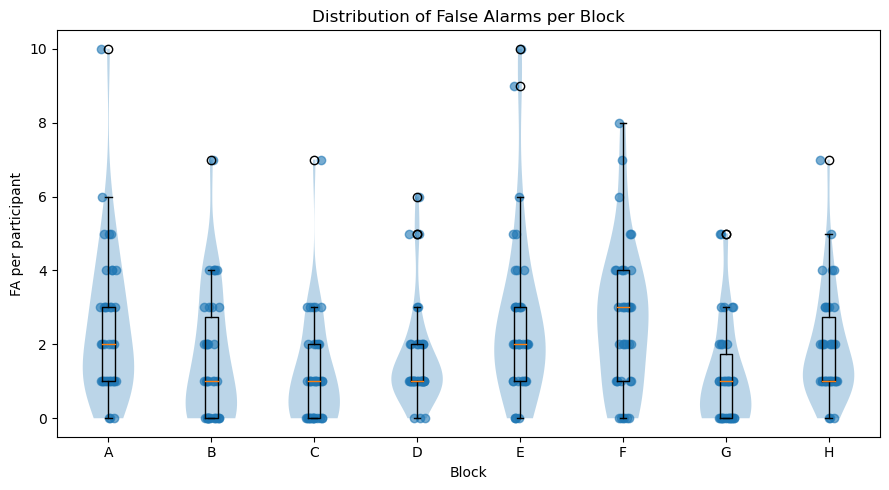

Saved: ['fa_dotplots/fa_dotplot_block_A.png', 'fa_dotplots/fa_dotplot_block_B.png', 'fa_dotplots/fa_dotplot_block_C.png'] ...


In [ ]:


show_block_distribution(fa_full)             # 每 block 的分布（小提琴+盒须+抖点）
files = export_block_dotplots(fa_full)       # 导出每个 block 的点图（返回文件路径列表）
print("Saved:", files[:3], "...")


# ergolab time alignment

## prepared data import

文件说明 
combined_blocks.csv 是没有去掉pra和无效被试和重复block的block汇总文件
combined_blocks_final.csv 是清洗后的block

ergolab_contain_block ergolab项目跟每个被试的block相关性


In [ ]:
# # block final 读取
# final_blocks_all = pd.read_csv("/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/combined_blocks_final.csv")
# ergolab_contain_block = pd.read_excel("/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/physio/ergolab_contain_block.xlsx")
# ergolab_info_summary = pd.read_csv("/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/physio/ergolab_info_summary.csv")
# cleaned_events = pd.read_csv("/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/combined_events_final.csv")

In [ ]:
# ergolab_contain_block_std = standardize_columns(ergolab_contain_block)
# ergolab_info_summary_std = standardize_columns(ergolab_info_summary)

# ergolab_merged = pd.merge(ergolab_contain_block_std, ergolab_info_summary_std, on=["participant_id","recording"], how="outer")
# blocks_ergolab_merged = pd.merge(final_blocks_all, ergolab_merged, on=["participant_id","block_label"], how="outer")

无效被试：9/26/37

In [ ]:
# # 去掉被试编号9 26 37
# blocks_ergolab_merged_cleaned = blocks_ergolab_merged[~blocks_ergolab_merged["participant_id"].isin([9, 26, 37])].reset_index(drop=True)
# # 去掉被试为na
# blocks_ergolab_merged_cleaned = blocks_ergolab_merged_cleaned[blocks_ergolab_merged_cleaned["participant_id"].notna()].reset_index(drop=True)

In [ ]:
# blocks_ergolab_merged_cleaned.to_csv("/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/blocks_ergolab_merged_cleaned.csv", index=False, encoding="utf-8-sig")

## 导出block时间轴

In [ ]:
# # Use pd.to_numeric to force non-numeric values into NaN
# blocks_ergolab_merged_cleaned['onset_time_ergo'] = pd.to_numeric(
#     blocks_ergolab_merged_cleaned['onset_time_ergo'], errors='coerce'
# )
# blocks_ergolab_merged_cleaned['offset_time_ergo'] = pd.to_numeric(
#     blocks_ergolab_merged_cleaned['offset_time_ergo'], errors='coerce'
# )

# # Now, fill the NaN values with 0 and convert to integer
# blocks_ergolab_merged_cleaned['onset_time_ergo'] = blocks_ergolab_merged_cleaned['onset_time_ergo']
# blocks_ergolab_merged_cleaned['offset_time_ergo'] = blocks_ergolab_merged_cleaned['offset_time_ergo']

# # Sort the values as you did before
# blocks_ergolab_merged_cleaned = blocks_ergolab_merged_cleaned.sort_values(['participant_id', 'recording'])


In [ ]:
# # 去掉onset_time_ergo 为na的行
# blocks_ergolab_merged_cleaned = blocks_ergolab_merged_cleaned[blocks_ergolab_merged_cleaned['onset_time_ergo'].notna()]
# # 每一列的类型
# cols = ["onset_time_ergo", "offset_time_ergo"]
# for c in cols:
#     s = pd.to_numeric(blocks_ergolab_merged_cleaned[c], errors="coerce")
#     s = s.round(0)          # 或者用 s.floor() / s.ceil()
#     blocks_ergolab_merged_cleaned[c] = s.astype("Int64")  # 可空整数



In [ ]:
def _pid2str2(x) -> str:
    """把被试编号转为两位字符串（NaN -> 'NA'）"""
    if pd.isna(x):
        return "NA"
    try:
        return f"{int(x):02d}"
    except Exception:
        # 万一是像 '001' 这种字符串
        s = str(x).strip()
        if s.isdigit():
            return f"{int(s):02d}"
        return "NA"

def _safe_name(s: str) -> str:
    """清理文件名中的不安全字符（只保留字母数字._-）"""
    s = str(s)
    return re.sub(r"[^A-Za-z0-9._-]+", "_", s)

def add_name_and_export_segment(blocks_df: pd.DataFrame, out_dir: str | Path) -> pd.DataFrame:
    """
    在 blocks_ergolab_merged_cleaned 上：
      1) 生成 name_ergo = 'P' + 两位participant_id + '-' + block_label
      2) 按 (participant_id, recording) 导出 CSV（每个CSV只含字符串列：onset_time_ergo, offset_time_ergo, name_ergo）
    返回：导出报告 DataFrame
    """
    need = {"participant_id", "block_label", "recording", "onset_time_ergo", "offset_time_ergo"}
    miss = need - set(blocks_df.columns)
    if miss:
        raise ValueError(f"缺少必要列：{miss}")

    df = blocks_df.copy()

    # 统一类型（不改变原列，只用于构造与排序）
    df["participant_id"] = pd.to_numeric(df["participant_id"], errors="coerce").astype("Int64")
    df["block_label"] = df["block_label"].astype(str)

    # 生成 name_ergo：P{两位}-Block（例如 P01-A）
    df["name_ergo"] = "P" + df["participant_id"].map(_pid2str2) + "-" + df["block_label"]

    # 为了导出排序更友好，先建数值版本的起止时间（不写回原表）
    onset_num = pd.to_numeric(df["onset_time_ergo"], errors="coerce")
    offset_num = pd.to_numeric(df["offset_time_ergo"], errors="coerce")

    # 准备输出目录
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # 分组导出
    records = []
    for (pid, rec), sub in df.groupby(["participant_id", "recording"], dropna=False):
        # 选择并排序
        sub = sub.copy()
        sub["_on"] = pd.to_numeric(sub["onset_time_ergo"], errors="coerce")
        sub["_off"] = pd.to_numeric(sub["offset_time_ergo"], errors="coerce")
        sub = sub.sort_values(["_on", "_off", "block_label"], kind="mergesort")

        # 只保留三列，并全部转为字符串（空值用空串）
        out = sub[["onset_time_ergo", "offset_time_ergo", "name_ergo"]].copy()
        for c in out.columns:
            out[c] = out[c].map(lambda v: "" if pd.isna(v) else str(v))

        # 文件名：P{两位}-{recording}-ergolabimport.csv
        pid2 = _pid2str2(pid)
        rec_safe = _safe_name(rec)
        fname = f"P{pid2}-{rec_safe}-ergolabimport.csv"
        fpath = out_dir / fname

        out.to_csv(fpath, index=False, encoding="utf-8-sig")
        records.append({
            "participant_id": int(pid) if pd.notna(pid) else None,
            "recording": rec,
            "rows": len(out),
            "file": str(fpath)
        })

    report = pd.DataFrame(records).sort_values(["participant_id","recording"]).reset_index(drop=True)
    return report

def add_name_and_export_event(blocks_df: pd.DataFrame, out_dir: str | Path) -> pd.DataFrame:
    """
    在 blocks_ergolab_merged_cleaned 上：
      1) 生成 name_ergo = 'P' + 两位participant_id + '-' + block_label
      2) 按 (participant_id, recording) 导出 CSV（每个CSV只含字符串列：onset_time_ergo, offset_time_ergo, name_ergo）
    返回：导出报告 DataFrame
    """
    need = {"participant_id", "block_label", "recording", "onset_time_ergo", "offset_time_ergo"}
    miss = need - set(blocks_df.columns)
    if miss:
        raise ValueError(f"缺少必要列：{miss}")

    df = blocks_df.copy()

    # 统一类型（不改变原列，只用于构造与排序）
    df["participant_id"] = pd.to_numeric(df["participant_id"], errors="coerce").astype("Int64")
    df["block_label"] = df["block_label"].astype(str)

    # 生成 name_ergo：P{两位}-Block（例如 P01-A）
    df["name_ergo"] = "P" + df["participant_id"].map(_pid2str2) + "-" + df["block_label"]

    # 为了导出排序更友好，先建数值版本的起止时间（不写回原表）
    onset_num = pd.to_numeric(df["onset_time_ergo"], errors="coerce")
    offset_num = pd.to_numeric(df["offset_time_ergo"], errors="coerce")

    # 准备输出目录
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # 分组导出
    records = []
    for (pid, rec), sub in df.groupby(["participant_id", "recording"], dropna=False):
        # 选择并排序
        sub = sub.copy()
        sub["_on"] = pd.to_numeric(sub["onset_time_ergo"], errors="coerce")
        sub["_off"] = pd.to_numeric(sub["offset_time_ergo"], errors="coerce")
        sub = sub.sort_values(["_on", "_off", "block_label"], kind="mergesort")

        # 只保留三列，并全部转为字符串（空值用空串）
        out = sub[["onset_time_ergo", "name_ergo"]].copy()
        out['onset_time_ergo'] = pd.to_numeric(out["onset_time_ergo"], errors="coerce")
        out['onset_time_ergo'] = out['onset_time_ergo'].round(0)
        out['onset_time_ergo'] = out['onset_time_ergo'].astype("Int64")
        for c in out.columns:
            out[c] = out[c].map(lambda v: "" if pd.isna(v) else str(v))

        # 文件名：P{两位}-{recording}-ergolabimport.csv
        pid2 = _pid2str2(pid)
        rec_safe = _safe_name(rec)
        fname = f"P{pid2}-{rec_safe}-block-event.csv"
        fpath = out_dir / fname

        out.to_csv(fpath, index=False, encoding="utf-8-sig")
        records.append({
            "participant_id": int(pid) if pd.notna(pid) else None,
            "recording": rec,
            "rows": len(out),
            "file": str(fpath)
        })

    report = pd.DataFrame(records).sort_values(["participant_id","recording"]).reset_index(drop=True)
    return report

OUT_DIR = "/Volumes/LYY_T7/13_抽象实验数据分析/2_code/test"
blocks_ergolab_merged_cleaned1 = pd.read_csv("/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/combined_blocks_ergolab_merged_cleaned1.csv")
report = add_name_and_export_event(blocks_ergolab_merged_cleaned1, OUT_DIR)
print("导出完成：")
display(report)


导出完成：


,participant_id,recording,rows,file
0,1,R1,2,/Volumes/LYY_T7/13_抽象实验数据分析/2_code/test/P01-R1...
1,1,R2,2,/Volumes/LYY_T7/13_抽象实验数据分析/2_code/test/P01-R2...
2,1,R3,4,/Volumes/LYY_T7/13_抽象实验数据分析/2_code/test/P01-R3...
3,2,R1,8,/Volumes/LYY_T7/13_抽象实验数据分析/2_code/test/P02-R1...
4,3,R1,4,/Volumes/LYY_T7/13_抽象实验数据分析/2_code/test/P03-R1...
5,3,R2,1,/Volumes/LYY_T7/13_抽象实验数据分析/2_code/test/P03-R2...
6,3,R3,3,/Volumes/LYY_T7/13_抽象实验数据分析/2_code/test/P03-R3...
7,4,R1,8,/Volumes/LYY_T7/13_抽象实验数据分析/2_code/test/P04-R1...
8,5,R1,2,/Volumes/LYY_T7/13_抽象实验数据分析/2_code/test/P05-R1...
9,5,R2,6,/Volumes/LYY_T7/13_抽象实验数据分析/2_code/test/P05-R2...


In [ ]:
# blocks_ergolab_merged_cleaned.to_csv("/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/combined_blocks_ergolab_merged_cleaned2.csv", index=False, encoding="utf-8")

## 导出事件的ergolab时间轴

In [10]:
def build_ergo_offsets_from_datetimes(blocks_df: pd.DataFrame,
                                      verify_with_abs: bool = True,
                                      verify_tol: float = 0.05):
    """
    依据绝对时间戳计算每个 (participant_id, block_label) 的 ergolab 偏移量（秒）：
        ergo_offset = (exp_start_time - create_time).total_seconds()

    参数
    ----
    blocks_df: DataFrame，需包含列：
        ['participant_id','block_label','exp_start_time','create_time']
        （可选：'abs_onset_time','onset_time' 用于校验）
    verify_with_abs: 若为 True 且存在 abs_onset_time/onset_time，则比较
        (exp_start_time - create_time) 与 (abs_onset_time - onset_time) 的中位数差
    verify_tol: 两种 offset 的绝对差超过该阈值（秒）将进入 mismatch 报告

    返回
    ----
    offsets: DataFrame，列：
        ['participant_id','block_label','ergo_offset','n_rows','recording','create_time']
    mismatches: DataFrame（可能为空），列：
        ['participant_id','block_label','offset_dt','offset_abs','diff_sec']
    """
    need = {"participant_id","block_label","exp_start_time","create_time"}
    miss = need - set(blocks_df.columns)
    if miss:
        raise ValueError(f"blocks_df 缺少列：{miss}")

    df = blocks_df.copy()
    # 类型
    df["participant_id"] = pd.to_numeric(df["participant_id"], errors="coerce").astype("Int64")
    df["exp_start_time"] = pd.to_datetime(df["exp_start_time"], errors="coerce")
    df["create_time"]    = pd.to_datetime(df["create_time"], errors="coerce")

    # 逐行计算由绝对时间得到的 offset（秒）
    df["_offset_dt"] = (df["exp_start_time"] - df["create_time"]).dt.total_seconds()

    # 组内汇总（有时同一 block 会有多行）
    out = (df.groupby(["participant_id","block_label"], dropna=False)
             .agg(ergo_offset=("_offset_dt", "median"),
                  n_rows=("block_label","size"),
                  recording=("recording","first") if "recording" in df.columns else ("_offset_dt","size"),
                  create_time=("create_time","first"))
             .reset_index())

    # 可选：与 abs_onset_time - onset_time 的 offset 做一致性校验
    mismatches = pd.DataFrame(columns=["participant_id","block_label","offset_dt","offset_abs","diff_sec"])
    if verify_with_abs and {"abs_onset_time","onset_time"}.issubset(df.columns):
        df["abs_onset_time"] = pd.to_numeric(df["abs_onset_time"], errors="coerce")
        df["onset_time"]     = pd.to_numeric(df["onset_time"], errors="coerce")
        df["_offset_abs"] = df["abs_onset_time"] - df["onset_time"]

        chk = (df.groupby(["participant_id","block_label"], dropna=False)
                 .agg(offset_dt=("_offset_dt","median"),
                      offset_abs=("_offset_abs","median"))
                 .reset_index())
        chk["diff_sec"] = (chk["offset_dt"] - chk["offset_abs"]).abs()
        mismatches = chk[chk["diff_sec"] > verify_tol].copy()

    return out[["participant_id","block_label","ergo_offset","n_rows","recording","create_time"]], mismatches

def export_ergolab_events(cleaned_events: pd.DataFrame,
                          offsets: pd.DataFrame,
                          out_dir: str | Path,
                          strict_missing_offset: bool = True,
                          decimals: int = 3) -> pd.DataFrame:
    """
    输入：
      cleaned_events: 含 ['participant_id','block_label','start_time','end_time','event_uid',...]
      offsets: 来自 build_ergo_offsets_from_datetimes(...) 的结果（含 'ergo_offset'）
      out_dir: 输出目录
    参数：
      strict_missing_offset: True -> 缺 offset 的事件丢弃；False -> 保留且 start/end 为 NaN
      decimals: 导出小数位
    返回：
      report: 每个导出文件的行数与路径
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    need_e = {"participant_id","block_label","start_time","end_time","event_uid"}
    miss_e = need_e - set(cleaned_events.columns)
    if miss_e:
        raise ValueError(f"cleaned_events 缺少列：{miss_e}")

    need_o = {"participant_id","block_label","ergo_offset","recording"}
    miss_o = need_o - set(offsets.columns)
    if miss_o:
        raise ValueError(f"offsets 缺少列：{miss_o}")

    ev = cleaned_events.copy()
    ev["participant_id"] = pd.to_numeric(ev["participant_id"], errors="coerce").astype("Int64")
    ev["start_time"] = pd.to_numeric(ev["start_time"], errors="coerce")
    ev["end_time"]   = pd.to_numeric(ev["end_time"], errors="coerce")

    off = offsets.copy()
    off["participant_id"] = pd.to_numeric(off["participant_id"], errors="coerce").astype("Int64")

    # 合并偏移量（按 (pid, block_label) 直接匹配，不改大小写/列名）
    merged = ev.merge(off[["participant_id","block_label","ergo_offset","recording"]],
                      on=["participant_id","block_label"], how="left")

    # 缺 offset 的处理
    missing_mask = merged["ergo_offset"].isna()
    n_missing = int(missing_mask.sum())
    if strict_missing_offset:
        merged = merged[~missing_mask].copy()

    # 计算 ergolab 相对时间
    merged["start_time_ergo"] = merged["start_time"] + merged["ergo_offset"]
    merged["end_time_ergo"]   = merged["end_time"]   + merged["ergo_offset"]
    # start_time_ergo 取整
    merged["start_time_ergo"] = pd.to_numeric(merged["start_time_ergo"],errors = "coerce").round(0).astype("Int64")
    merged["end_time_ergo"]   = pd.to_numeric(merged["end_time_ergo"],errors = "coerce").round(0).astype("Int64")
    # 只保留导出所需列
    out_cols = ["participant_id","block_label","start_time_ergo","end_time_ergo","event_uid","recording"]
    merged_out = merged[out_cols].copy()

    # 生成 name_ergo：P{两位}-Block（例如 P01-A）
    merged_out["name_ergo"] = (
    "P" + merged_out["participant_id"].map(_pid2str2)
    + "-" + merged_out["block_label"]
    + "-" + merged_out["event_uid"].astype(str).str[:5]
    )

    # 分组导出
    records = []
    for (pid, rec), sub in merged_out.groupby(["participant_id", "recording"], dropna=False):
        sub = sub.sort_values(["start_time_ergo", "end_time_ergo", "name_ergo"])
        sub_segment = sub[["start_time_ergo", "end_time_ergo", "name_ergo"]]
        recording_val = sub["recording"].iloc[0] if "recording" in sub.columns else "NA"
        fname_seg = f"{int(pid) if pd.notna(pid) else 'NA'}-{rec}-{recording_val}-ergolabimport.csv"
        fpath_seg = out_dir / "segment" / fname_seg
        sub_segment.to_csv(fpath_seg, index=False, encoding="utf-8", float_format=f"%.{decimals}f")

        sub_event = sub[["start_time_ergo", "event_uid"]]
        fname_event = f"{int(pid) if pd.notna(pid) else 'NA'}-{rec}-{recording_val}-ergolabimport.csv"
        fpath_ev = out_dir / "event" / fname_event
        sub_event.to_csv(fpath_ev, index=False, encoding="utf-8", float_format=f"%.{decimals}f")
        records.append({
            "participant_id": int(pid) if pd.notna(pid) else None,
            "recording": rec,
            "rows": len(sub),
            "file": str(fpath_ev)
        })

    report = pd.DataFrame(records).sort_values(["participant_id","recording"]).reset_index(drop=True)

    if n_missing > 0:
        print(f"[提示] 有 {n_missing} 条事件缺少 offset（该 (pid, rec) 不在 offsets 中）。"
              f"{'这些事件已丢弃。' if strict_missing_offset else '这些事件已保留但时间为 NaN。'}")

    return report


In [18]:
def _pid2str2(x) -> str:
    try:
        return f"{int(x):02d}"
    except Exception:
        return "NA"

def _safe_name(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+", "_", str(s))

def export_ergolab_events(
    cleaned_events: pd.DataFrame,
    offsets: pd.DataFrame,
    out_dir: str | Path,
    strict_missing_offset: bool = True,
    extra_rec_offsets: dict[tuple[int, str], float] | None = None,  # {(pid, "p01-r1"): +1.5, ...}
):
    """
    依据 offsets 计算每条事件的 start/end 相对 create_time 的时间（秒），
    可选对 (participant_id, recording) 整段统一平移若干秒，然后导出：
      - segment/{pid}-{recording}-ergolabimport.csv: start_time_ergo,end_time_ergo,name_ergo（字符串）
      - event/{pid}-{recording}-events.csv: start_time_ergo,event_uid（字符串）
    """
    out_dir = Path(out_dir)
    seg_dir = out_dir / "segment"
    evt_dir = out_dir / "event"
    seg_dir.mkdir(parents=True, exist_ok=True)
    evt_dir.mkdir(parents=True, exist_ok=True)

    need_e = {"participant_id","block_label","start_time","end_time","event_uid"}
    miss_e = need_e - set(cleaned_events.columns)
    if miss_e:
        raise ValueError(f"cleaned_events 缺少列：{miss_e}")

    need_o = {"participant_id","block_label","ergo_offset","recording"}
    miss_o = need_o - set(offsets.columns)
    if miss_o:
        raise ValueError(f"offsets 缺少列：{miss_o}")

    ev = cleaned_events.copy()
    ev["participant_id"] = pd.to_numeric(ev["participant_id"], errors="coerce").astype("Int64")
    ev["start_time"] = pd.to_numeric(ev["start_time"], errors="coerce")
    ev["end_time"]   = pd.to_numeric(ev["end_time"], errors="coerce")

    off = offsets.copy()
    off["participant_id"] = pd.to_numeric(off["participant_id"], errors="coerce").astype("Int64")

    # 合并偏移量 -> 计算 ergo 时间（浮点）
    merged = ev.merge(off[["participant_id","block_label","ergo_offset","recording"]],
                      on=["participant_id","block_label"], how="left")

    missing_mask = merged["ergo_offset"].isna()
    n_missing = int(missing_mask.sum())
    if strict_missing_offset:
        merged = merged[~missing_mask].copy()

    merged["start_time_ergo_f"] = merged["start_time"] + merged["ergo_offset"]
    merged["end_time_ergo_f"]   = merged["end_time"]   + merged["ergo_offset"]

    # ===== 整段 recording 统一平移（可选）=====
    applied_rec_shifts_rows = 0
    if extra_rec_offsets:
        # 为每行找对应平移秒数（不存在则 0）
        deltas = []
        for pid, rec in zip(merged["participant_id"], merged["recording"].astype(str)):
            key = (int(pid) if pd.notna(pid) else None, rec)
            deltas.append(extra_rec_offsets.get(key, 0.0))
            #print(f"为 (P{_pid2str2(pid)}-{rec}) 找到平移：{deltas[-1]} s")
        merged["_delta"] = pd.Series(deltas, index=merged.index, dtype="float64")

        mask_delta = merged["_delta"].ne(0)
        applied_rec_shifts_rows = int(mask_delta.sum())
        merged.loc[mask_delta, "start_time_ergo_f"] += merged.loc[mask_delta, "_delta"]
        merged.loc[mask_delta, "end_time_ergo_f"]   += merged.loc[mask_delta, "_delta"]

    # 最终取整为“秒”，再转字符串导出
    merged["start_time_ergo"] = pd.to_numeric(merged["start_time_ergo_f"], errors="coerce").round().astype("Int64")
    merged["end_time_ergo"]   = pd.to_numeric(merged["end_time_ergo_f"],   errors="coerce").round().astype("Int64")

    # name_ergo: P{两位}-{Block}（若你要附加事件片段，可自行拼接）
    merged["name_ergo"] = (
    "P" + merged["participant_id"].map(_pid2str2)
    + "-" + merged["block_label"]
    + "-" + merged["event_uid"].astype(str).str[:5]
    )

    merged["name_ergo_ev"] = (
    merged["block_label"]
    + "-" + merged["event_uid"].astype(str).str[:5]
    )

    out_cols = ["participant_id","block_label","start_time_ergo","end_time_ergo","event_uid","recording","name_ergo","name_ergo_ev"]
    merged_out = merged[out_cols].copy()

    # ========= 导出（转字符串）=========
    records = []
    for (pid, rec), sub in merged_out.groupby(["participant_id","recording"], dropna=False):
        sub = sub.sort_values(["start_time_ergo","end_time_ergo","name_ergo"])

        # segment 文件（三列均为字符串）
        seg = sub[["start_time_ergo","end_time_ergo","name_ergo"]].copy()
        for c in ["start_time_ergo","end_time_ergo"]:
            seg[c] = seg[c].map(lambda v: "" if pd.isna(v) else str(int(v)))
        seg["name_ergo"] = seg["name_ergo"].fillna("").astype(str)
        fname_seg = f"{int(pid) if pd.notna(pid) else 'NA'}-{_safe_name(rec)}-ergolabimport.csv"
        seg.to_csv(seg_dir / fname_seg, index=False, encoding="utf-8")

        # event 文件（两列字符串）
        evf = sub[["start_time_ergo","name_ergo"]].copy()
        evf["start_time_ergo"] = evf["start_time_ergo"].map(lambda v: "" if pd.isna(v) else str(int(v)))
        evf["name_ergo"] = evf["name_ergo"].astype(str)
        fname_evt = f"{int(pid) if pd.notna(pid) else 'NA'}-{_safe_name(rec)}-events.csv"
        evf.to_csv(evt_dir / fname_evt, index=False, encoding="utf-8")

        records.append({
            "participant_id": int(pid) if pd.notna(pid) else None,
            "recording": rec,
            "rows_segment": len(seg),
            "rows_event": len(evf),
            "file_segment": str(seg_dir / fname_seg),
            "file_event": str(evt_dir / fname_evt),
        })

    report = pd.DataFrame(records).sort_values(["participant_id","recording"]).reset_index(drop=True)

    if n_missing > 0:
        print(f"[提示] 有 {n_missing} 条事件缺少 offset（该 (pid, block) 未在 offsets 中）。这些事件已丢弃。")
    if extra_rec_offsets:
        print(f"[记录] 整段 recording 平移：影响行数 {applied_rec_shifts_rows}")

    return report


In [25]:
# 1) 从 blocks 计算偏移量（秒），并做一致性校验报告
offsets, mismatches = build_ergo_offsets_from_datetimes(blocks_ergolab_merged_cleaned,
                                                        verify_with_abs=True,
                                                        verify_tol=0.05)
print(f"计算得到 {len(offsets)} 个 (participant_id, block_label) 的偏移量")

extra_rec_offsets = {
    (1, "R1"): 2,
    (1, "R2"): 1,
    (1,"R3"):-1,
    (2,"R1"):0,
    (3,"R1"):-2,
    (3,"R2"):0,
    (3,"R3"):-1, # 这个记记录往上已经确认了
    (4,"R1"):-1,#
    (5,"R1"):-1,
    (5,"R2"):-1,
    (6,"R1"):-1,
    (7,"R1"):-1,
    (8,"R1"):-1,
    (8,"R2"):-1,
    (10,"R1"):-1,
    (11,"R1"):-1,
    (11,"R2"):-1,
    (11,"R3"):-1,
    (12,"R1"):-1,
    (13,"R1"):-1,
    (14,"R1"):-1,
    (15,"R1"):-1,
    (16,"R1"):-1,
    (17,"R1"):-1,
    (18,"R1"):-1,
    (19,"R1"):-1,
    (20,"R1"):-1,
    (21,"R1"):-1,
    (22,"R1"):-1,
    (23,"R1"):-1,
    (24,"R1"):-1,
    (25,"R1"):-1,
    (27,"R1"):-1,
    (27,"R2"):-1,
    (28,"R1"):-1,
    (29,"R1"):-1,
    (30,"R1"):-1,
    (31,"R1"):-1,
    (32,"R1"):-1,
    (32,"R2"):-1,
    (33,"R1"):-1,
    (34,"R1"):-1,
    (35,"R1"):-1,
    (36,"R1"):-1,
    (38,"R1"):-1,
    (38,"R2"):-1,
}

report = export_ergolab_events(
    cleaned_events=cleaned_events,
    offsets=offsets,
    out_dir="./ergolab_import_events",
    strict_missing_offset=True,
    extra_rec_offsets=extra_rec_offsets,
)
display(report.head())



计算得到 280 个 (participant_id, block_label) 的偏移量
[记录] 整段 recording 平移：影响行数 14540


,participant_id,recording,rows_segment,rows_event,file_segment,file_event
0,1,R1,108,108,ergolab_import_events/segment/1-R1-ergolabimpo...,ergolab_import_events/event/1-R1-events.csv
1,1,R2,108,108,ergolab_import_events/segment/1-R2-ergolabimpo...,ergolab_import_events/event/1-R2-events.csv
2,1,R3,216,216,ergolab_import_events/segment/1-R3-ergolabimpo...,ergolab_import_events/event/1-R3-events.csv
3,2,R1,432,432,ergolab_import_events/segment/2-R1-ergolabimpo...,ergolab_import_events/event/2-R1-events.csv
4,3,R1,216,216,ergolab_import_events/segment/3-R1-ergolabimpo...,ergolab_import_events/event/3-R1-events.csv


# 读取问卷数据

In [26]:
que_block = pd.read_excel("/Volumes/LYY_T7/13_抽象实验数据分析/1_rawdata/questionnaire/318327928_按序号_Block后测问卷_340_340.xlsx")

# 重命名que_block
que_block = que_block.rename(columns={
    "1、被试编号": "participant_id",
    "2、block 编号": "block_label",
    "3、脑力需求完成这个任务，需要你付出多少的脑力活动（例如思考、决策、计算、记忆、观察、搜索等)？这个任务从脑力方面对你而言是容易还是困难，简单还是复杂，严格还是宽容？": "mental_demand",
    "4、体力需求完成这个任务，需要你付出完成多少体力活动（例如推、拉、转向、控制、激活等)？这个任务是容易还是费力，做起来是轻松还是困难？": "physical_demand",
    "5、时间需求由于这个任务或任务中部分内容的进展节奏或速度，你感到多大的时间压力？这个任务的节奏是缓慢悠闲的还是快速、令人慌乱的？" : "temporal_demand",
    "6、努力程度对于你取得的绩效表现，你付出了多大的努力（包括脑力和体力)？" : "effort",
    "7、挫败感（受挫程度）在完成任务的过程中，你感到不安全、灰心、烦恼、压力和焦虑的程度如何（与安全、满足、 放松、满意相对)？" : "frustration",
    "8、绩效表现对于我们给定的实验任务，你认为自己完成的有多成功？你对自己在完成任务中的表现有多满意？" : "performance",
    "9、请按照您完成实验任务时的实际感受选择相应分值" : "SSS",
    "10、“我觉得刚刚完成的任务很难。”请选择最符合您感受的选项：" : "perceived_difficulty"
    # 继续添加其他列的重命名
})

print(que_block.columns)

# 保留'participant_id','block_label', 'mental_demand', 'physical_demand', 'temporal_demand', 'effort', 'frustration', 'performance', 'SSS', 'perceived_difficulty'
que_block_filtered = que_block[[
    'participant_id','block_label', 'mental_demand', 'physical_demand', 'temporal_demand', 'effort', 'frustration', 'performance', 'SSS', 'perceived_difficulty'
]] 
# 去掉perceived_difficulty为na的行
que_block_filtered = que_block_filtered[que_block_filtered['perceived_difficulty'].notna()]
# 去掉被试编号为无效被试：9/26/37
que_block_filtered = que_block_filtered[~que_block_filtered['participant_id'].isin([9, 26, 37])]
# que_block_filtered 的 block_labels 从内容的1-8一一映射成A-H
que_block_filtered['block_label'] = que_block_filtered['block_label'].map({1:'A', 2:'B', 3:'C', 4:'D', 5:'E', 6:'F', 7:'G', 8:'H'})
que_block_filtered.loc[que_block_filtered['participant_id'] == 0,'participant_id'] = 4
que_block_filtered[que_block_filtered['participant_id'] == 4]
# 11 号的C做了两遍，选择第一遍的回答
# 11号的C做了两遍，选择第一遍的回答（只保留participant_id=11, block_label='C'的第一条）
mask = (que_block_filtered['participant_id'] == 11) & (que_block_filtered['block_label'] == 'C')
if mask.sum() > 1:
    first_idx = que_block_filtered[mask].index[0]
    que_block_filtered = que_block_filtered.drop(que_block_filtered[mask].index[1:])
que_block_filtered.to_csv("/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/questionnaire_block_cleaned.csv", index=False, encoding="utf-8-sig")

Index(['序号', '提交答卷时间', '所用时间', '来源', '来源详情', '来自IP', '总分', 'participant_id',
       'block_label', 'mental_demand', 'physical_demand', 'temporal_demand',
       'effort', 'frustration', 'performance', 'SSS', 'perceived_difficulty'],
      dtype='object')


# 初步分析

In [43]:
# 分类汇总每个被试在每个block下miss了多少事件，统计is_miss==True的数量,0也要呈现
missed_events_summary = cleaned_events[cleaned_events["is_miss"]].groupby(["participant_id", "block_label"]).size().reset_index(name="missed_count")
missed_events_summary

,participant_id,block_label,missed_count
0,1,A,4
1,1,C,2
2,1,D,1
3,1,F,1
4,2,E,1
...,...,...,...
180,38,D,6
181,38,E,3
182,38,F,5
183,38,G,3


## 反应时

In [ ]:
# clean_event 按照 participant_id 和 block_label 分组汇总is_hit的数量
clean_event_summary = cleaned_events.groupby(['participant_id', 'block_label'])['is_hit'].sum().reset_index()

# 命中率计算：is_hit / 54
clean_event_summary['hit_rate'] = clean_event_summary['is_hit'] / 54

# 反应时计算，cleaned_events中的
cleaned_events['Reaction_time'] = cleaned_events['first_click_ts'] - (cleaned_events['end_time']-1.3)
# 分组统计is_hit为True的反应时均值
reaction_time_summary = cleaned_events[cleaned_events['is_hit']].groupby(['participant_id', 'block_label'])['Reaction_time'].mean().reset_index()

# 合并两个df
event_summary = pd.merge(clean_event_summary, reaction_time_summary, on=['participant_id', 'block_label'], how='outer')

event_summary.to_csv("/Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/event_summary.csv", index=False, encoding="utf-8-sig") 

# 按照participant_id 汇总
event_summary_participant = event_summary.groupby('participant_id').agg({
    'hit_rate': 'mean',
    'Reaction_time': 'mean'
}).reset_index()

# 给出每个被试在hit_rate和Reaction_time上的排名
event_summary_participant['hit_rate_rank'] = event_summary_participant['hit_rate'].rank(ascending=False)
event_summary_participant['Reaction_time_rank'] = event_summary_participant['Reaction_time'].rank(ascending=True)

event_summary_participant

     participant_id block_label  is_hit  hit_rate  Reaction_time
0                 1           A      50  0.925926       0.744810
1                 1           B      54  1.000000       0.627677
2                 1           C      52  0.962963       0.805190
3                 1           D      53  0.981481       0.810832
4                 1           E      54  1.000000       0.624608
..              ...         ...     ...       ...            ...
274              38           D      48  0.888889       1.000228
275              38           E      51  0.944444       0.650123
276              38           F      49  0.907407       0.700788
277              38           G      67  1.240741       0.973975
278              38           H      51  0.944444       0.937758

[279 rows x 5 columns]


In [ ]:
event_summary_que = pd.merge(event_summary, que_block_filtered, on=['participant_id', 'block_label'], how='outer')


In [24]:
event_summary_que.groupby(['block_label']).agg({
    'hit_rate' : 'mean',
    'Reaction_time': 'mean',
    'mental_demand': 'mean',
    'physical_demand': 'mean',
    'temporal_demand': 'mean',
    'effort': 'mean',
    'frustration': 'mean',
    'performance': 'mean',
    'SSS': 'mean',
    'perceived_difficulty': 'mean'
}).reset_index()

,block_label,hit_rate,Reaction_time,mental_demand,physical_demand,temporal_demand,effort,frustration,performance,SSS,perceived_difficulty
0,A,0.974074,0.520622,55.571429,42.314286,55.171429,68.085714,29.542857,72.200000,2.457143,3.971429
1,B,0.976720,0.504092,58.457143,41.714286,52.228571,65.685714,29.714286,72.714286,2.514286,3.942857
2,C,0.975309,0.782600,54.027778,44.194444,55.444444,64.000000,29.166667,72.000000,2.472222,3.555556
3,D,0.979894,0.771498,52.114286,42.085714,56.971429,68.514286,27.485714,76.628571,2.114286,3.771429
4,E,0.947168,0.585509,59.500000,45.088235,55.852941,69.529412,35.764706,63.823529,2.911765,4.029412
5,F,0.948148,0.611455,58.342857,45.742857,57.028571,70.057143,37.114286,62.485714,2.485714,4.171429
6,G,0.977778,0.811351,54.171429,45.285714,53.085714,65.485714,28.657143,71.971429,2.657143,3.600000
7,H,0.975661,0.811330,58.057143,45.742857,53.800000,68.028571,27.257143,75.685714,2.514286,3.828571
